<a href="https://colab.research.google.com/github/pnjha/NLP-Assignments/blob/master/nlp_q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 48kB/s 
     |████████████████████████████████| 419kB 58.2MB/s 
     |████████████████████████████████| 3.0MB 40.4MB/s 


In [1]:
import unicodedata
import pandas as pd
import numpy as np
import tensorflow as tf
import dill
import pickle
import weakref
from matplotlib.pyplot import *
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import copy
import math
import seaborn as sns; sns.set()
import keras as keras
from keras.optimizers import SGD
from keras.initializers import RandomUniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout, Activation, dot, concatenate, Bidirectional
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [2]:
tf.__version__

'2.0.0-alpha0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [78]:
X = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.en', names=['src'])
Y_in = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.hi', names=['dest_in'])
Y_out = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.hi', names=['dest_out'])
lines = pd.concat([X[:1000],Y_in[:1000],Y_out[:1000]], axis=1)
print(len(lines))
# lines = shuffle(lines)
lines.sample(10)

1000


,src,dest_in,dest_out
873,There are also measures to stop and reduce bre...,स्तनकैंसर रोकने और कम करने का भी उपाय है ।,स्तनकैंसर रोकने और कम करने का भी उपाय है ।
622,A great pain occurs in the joints in Chikungun...,चिकुनगुनिया में जोड़ों मे भारी दर्द होता है ।,चिकुनगुनिया में जोड़ों मे भारी दर्द होता है ।
881,For all this what is most important is awarene...,इस सब के लिए जो सबसे आवश्यक है वह है महिलाओं म...,इस सब के लिए जो सबसे आवश्यक है वह है महिलाओं म...
23,It is visible in dim light .,कम रोशनी में दिखाई देता है ।,कम रोशनी में दिखाई देता है ।
163,List of hospitals where the treatment of cance...,अस्पताल की सूची जहाँ कैंसर के इलाज की सुविधा है ।,अस्पताल की सूची जहाँ कैंसर के इलाज की सुविधा है ।
696,For good health of the eyes one should have vi...,जब श्‍लेष्मा का निकलना बंद हो जाये तब पेचिश रो...,जब श्‍लेष्मा का निकलना बंद हो जाये तब पेचिश रो...
897,Rice is very qualitative .,चावल बहुत गुणकारी होता है ।,चावल बहुत गुणकारी होता है ।
430,"If needed , lab tests of ECG , RFT , LFT , EEG...","जरूरत पड़ने पर लैब जाँच में ई.सी.जी. , आर.एफ.ट...","जरूरत पड़ने पर लैब जाँच में ई.सी.जी. , आर.एफ.ट..."
501,The birth of undeveloped baby may also occur d...,अविकसित शिशुओं का जन्म भी यौन संक्रमित रोगों क...,अविकसित शिशुओं का जन्म भी यौन संक्रमित रोगों क...
139,"The women whose mothers , sister , blood aunts...","जिन महिलाओं की माताओं , बहनों , मौसियों आदि को...","जिन महिलाओं की माताओं , बहनों , मौसियों आदि को..."


In [0]:
def process_data(data,append_char):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: x.strip())
    data = data.apply(lambda x: re.sub("'", '', x))
    exclude = set(string.punctuation) # Set of all special characters
    data = data.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
    remove_digits = str.maketrans('', '', digits)
    data = data.apply(lambda x: x.translate(remove_digits))
    if append_char == 1:
        data = data.apply(lambda x : '<sos> '+ x)
    elif append_char == 2:
        data = data.apply(lambda x : x + ' <eos>')
    return data

In [80]:
lines.src = process_data(lines.src,0)
lines.dest_in = process_data(lines.dest_in,1)
lines.dest_out = process_data(lines.dest_out,2)
lines.src.sample(10),lines.dest_in.sample(10),lines.dest_out.sample(10)

(464    there are only  percent of institutional deliv...
 56     due to changes in our lifestyle the number of ...
 458    more than three fourth of the women lrb  perce...
 617    abnormal state of any part of skin is called s...
 173                       bringing awareness in society 
 133    the danger of breast cancer increases in age a...
 322    the infant mortality rate of the state was  ev...
 820          the wound does not pain if there is cancer 
 451    the national maternity benefit scheme is being...
 515    the tuberculosis disease spreads through air f...
 Name: src, dtype: object,
 378    <sos> घाव एवं अल्सर की अवस्था में भी रोगी का प...
 316    <sos> सामान्य रूप से मैदानी क्षेत्रों की तुलना...
 900    <sos> यदि रात्रि के भोजन में रोटी कम खाएँ और च...
 825                            <sos> गाँठ में घाव बनना ।
 866    <sos> कई बार विशेषकर गाँवों  कसबों  झोंपड़पट्टी...
 514    <sos> तपेदिक माइक्रोबैक्टीरियम टयूबरकुलोसिस ना...
 425    <sos> बच्चों की छोटी  छोटी बातों से ज

In [0]:
X, y_in, y_out = lines.src.values, lines.dest_in.values, lines.dest_out.values 
X_train, X_test, y_in_train, y_in_test, y_out_train, y_out_test = train_test_split(X, y_in, y_out, test_size = 0.2,shuffle=False)

In [0]:
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
src_tokenizer.fit_on_texts(X_train)

data_src = src_tokenizer.texts_to_sequences(X_train)
data_src = tf.keras.preprocessing.sequence.pad_sequences(data_src,padding='post')

In [83]:
dest_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

dest_tokenizer.fit_on_texts(y_in_train)
dest_tokenizer.fit_on_texts(y_out_train)

data_dest_in = dest_tokenizer.texts_to_sequences(y_in_train)
data_dest_in = tf.keras.preprocessing.sequence.pad_sequences(data_dest_in,padding='post')

data_dest_out = dest_tokenizer.texts_to_sequences(y_out_train)
data_dest_out = tf.keras.preprocessing.sequence.pad_sequences(data_dest_out,padding='post')

print(data_dest_in.shape)
print(data_dest_out.shape)

(800, 58)
(800, 58)


In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Encoder, self).__init__()
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm_1 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_2 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm_1(embed, initial_state=states)
        output, state_h, state_c = self.lstm_2(output, initial_state=[state_h,state_c])
        return output, state_h, state_c

    def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.lstm_size]),
                tf.zeros([batch_size, self.lstm_size]))

In [0]:
class LuongAttention(tf.keras.Model):
    def __init__(self, lstm_size):
        super(LuongAttention, self).__init__()
        self.wa = tf.keras.layers.Dense(lstm_size)

    def call(self, decoder_output, encoder_output):
        score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=2)
        context_vector = tf.matmul(attention_weights, encoder_output)
        return context_vector, attention_weights

In [0]:
class LuongAttentionDot(tf.keras.Model):
    def __init__(self, lstm_size):
        super(LuongAttentionDot, self).__init__()
        self.wa = tf.keras.layers.Dense(lstm_size)

    def call(self, decoder_output, encoder_output):
        score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=2)
        context_vector = tf.matmul(attention_weights, encoder_output)
        return context_vector, attention_weights

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, lstm_size):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(lstm_size)
    self.W2 = tf.keras.layers.Dense(lstm_size)
    self.V = tf.keras.layers.Dense(1)

  def call(self, decoder_output, encoder_output):
    
    score = self.V(tf.nn.tanh(self.W1(decoder_output) + self.W2(encoder_output)))
    score = tf.transpose(score,perm=[0,2,1])
    
    attention_weights = tf.nn.softmax(score, axis=2)
    context_vector = tf.matmul(attention_weights, encoder_output)
    return context_vector, attention_weights

In [0]:
class BahdanauAttentionCoverage(tf.keras.Model):
  def __init__(self, lstm_size):
    super(BahdanauAttentionCoverage, self).__init__()
    self.coverage = None
    self.W1 = tf.keras.layers.Dense(lstm_size,name="W1")
    self.W2 = tf.keras.layers.Dense(lstm_size,name="W2")
    self.W3 = tf.keras.layers.Dense(lstm_size,name="W3")
    self.W4 = tf.keras.layers.Dense(lstm_size,name="W4")
    self.W5 = tf.keras.layers.Dense(lstm_size,name="W5")
    self.W6 = tf.keras.layers.Dense(lstm_size,name="W6")
    self.W7 = tf.keras.layers.Dense(lstm_size,name="W7")
    self.V1 = tf.keras.layers.Dense(1,name="V1")
    self.V2 = tf.keras.layers.Dense(1,name="V2")

  def call(self, decoder_output, encoder_output):
    
    if self.coverage is None: 
      self.coverage = decoder_output

    score = self.V1(tf.nn.tanh(self.W1(decoder_output) + self.W2(encoder_output) + self.W3(self.coverage)))
    score = tf.transpose(score,perm=[0,2,1])
    
    self.coverage = self.V1(tf.nn.tanh(self.W4(decoder_output) + self.W5(encoder_output) + self.W6(self.coverage)))
    self.coverage = tf.reshape(self.coverage, tf.shape(encoder_output).numpy())
    # print(self.coverage.shape, decoder_output.shape, encoder_output.shape)


    attention_weights = tf.nn.softmax(score, axis=2)
    context_vector = tf.matmul(attention_weights, encoder_output)
    # print(score.shape,decoder_output.shape,encoder_output.shape,attention_weights.shape,context_vector.shape)
    return context_vector, attention_weights


In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size, attn_type):
        super(Decoder, self).__init__()

        if attn_type == 'LuongAttention':
          self.attention = LuongAttention(lstm_size)
        elif attn_type == 'LuongAttentionDot':
          self.attention = LuongAttentionDot(lstm_size)
        elif attn_type == 'BahdanauAttention':
          self.attention = BahdanauAttention(lstm_size)
        elif attn_type == 'BahdanauAttentionCoverage':
          self.attention = BahdanauAttentionCoverage(lstm_size)
        
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm_1 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_2 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(lstm_size, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, sequence, state, encoder_output):

        embed = self.embedding(sequence)
        
        lstm_out, state_h, state_c = self.lstm_1(embed, initial_state=state)
        lstm_out, state_h, state_c = self.lstm_2(lstm_out, initial_state=[state_h,state_c])
        context, alignment = self.attention(lstm_out, encoder_output)

        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)
        lstm_out = self.wc(lstm_out)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

In [0]:
BATCH_SIZE = 50
EMBEDDING_SIZE = 256
LSTM_SIZE = 300

In [91]:
dataset = tf.data.Dataset.from_tensor_slices((data_src, data_dest_in, data_dest_out))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)
print(dataset)

<BatchDataset shapes: ((None, 57), (None, 58), (None, 58)), types: (tf.int32, tf.int32, tf.int32)>


In [0]:
def get_model(attn_type):
  src_vocab_size = len(src_tokenizer.word_index) + 1
  dest_vocab_size = len(dest_tokenizer.word_index) + 1

  encoder = Encoder(src_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)
  decoder = Decoder(dest_vocab_size, EMBEDDING_SIZE, LSTM_SIZE,attn_type)
  return encoder, decoder

In [0]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01,initial_accumulator_value=0.2)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.03)

In [0]:
def train_step(model,source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    encoder = model["encoder"]
    decoder = model["decoder"]
    with tf.GradientTape() as tape:
        en_outputs = encoder(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states
        
        for i in range(target_seq_out.shape[1]):          
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])
            loss += loss_func(target_seq_out[:, i], logit)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]

In [0]:
def train_model(attn_type,NUM_EPOCHS):
  encoder, decoder = get_model(attn_type)
  model = {"encoder":encoder,"decoder":decoder}
  loss_list = []
  ep_list = []

  en_initial_states = encoder.init_states(BATCH_SIZE)
  for e in range(NUM_EPOCHS):
  
      for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
          loss = train_step(model, source_seq, target_seq_in,target_seq_out, en_initial_states)
      
      ep_list.append(e+1)
      loss_list.append(loss.numpy())
      print('Epoch {} Loss {:.8f}'.format(e + 1, loss.numpy()))
  return encoder, decoder, loss_list, ep_list

In [0]:
def predict(model,test_source_text):
    
    encoder = model["encoder"]
    decoder = model["decoder"]
    src_tokenizer = model["src_tokenizer"]
    dest_tokenizer = model["dest_tokenizer"]

    test_source_seq = src_tokenizer.texts_to_sequences([test_source_text])

    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)

    de_input = tf.constant([[dest_tokenizer.word_index['<sos>']]])
    de_state_h, de_state_c = en_outputs[1:]
    out_words = []
    alignments = []

    while True:
        de_output, de_state_h, de_state_c, alignment = decoder(de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        try:
          out_words.append(dest_tokenizer.index_word[de_input.numpy()[0][0]])
        except:
          out_words.append('<unk>')
        alignments.append(alignment.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 50:
            break

    out_words = ' '.join(out_words)
    return np.array(alignments), out_words

In [0]:
def calculate_bleu_score(actual_string, predicted_string):
    actual_string = copy.deepcopy(actual_string)
    predicted_string = copy.deepcopy(predicted_string)
    reference = re.split("\s",actual_string.strip())
    candidate = re.split("\s",predicted_string.strip())
    try:
      reference.remove('<eos>')
      candidate.remove('<sos>')
    except:
      pass
    smoothie = SmoothingFunction().method4
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    return score

In [0]:

def plot_graph(xlist,ylist,xname,yname):
  x = np.array(xlist)
  y = np.array(ylist)
  d = {xname: x, yname: y}
  data = pd.DataFrame(d)
  sns.lineplot(x=xname, y=yname,data = data)
  plt.show()

In [0]:
def get_prediction(X,y,model):
  for index,line in enumerate(X):
    alignment, output = predict(model,line)
    print("source: ",line)
    print("actual: ",y[index])
    print("predicted: ",output)
    print("BLEU Score: ",calculate_bleu_score(output,y[index]))
    ax = sns.heatmap(alignment[:,0,0,:],linewidths=.2,cmap="YlGnBu")
    plt.show()

In [0]:
attn_type = 'BahdanauAttention'
# attn_type = 'LuongAttentionDot'
# attn_type = 'LuongAttention'
# attn_type = 'BahdanauAttentionCoverage'

NUM_EPOCHS = 500
encoder, decoder, loss_list,epoch_list = train_model(attn_type,NUM_EPOCHS)
model = {"encoder":encoder, "decoder":decoder, "attn_type":attn_type, "src_tokenizer":src_tokenizer, "dest_tokenizer":dest_tokenizer}
# model = { "attn_type":attn_type, "src_tokenizer":src_tokenizer, "dest_tokenizer":dest_tokenizer}

plot_graph(epoch_list,loss_list,"Epochs","Loss")


Epoch 1 Loss 2.50929093
Epoch 2 Loss 2.73400283
Epoch 3 Loss 2.39444733
Epoch 4 Loss 2.38634658
Epoch 5 Loss 2.33769941
Epoch 6 Loss 2.34803843
Epoch 7 Loss 2.30269098
Epoch 8 Loss 2.30280662
Epoch 9 Loss 2.27550364
Epoch 10 Loss 2.15101337
Epoch 11 Loss 2.11207533
Epoch 12 Loss 2.02798271
Epoch 13 Loss 2.01082635
Epoch 14 Loss 1.94718087
Epoch 15 Loss 1.93270874
Epoch 16 Loss 1.91669571
Epoch 17 Loss 1.89886224
Epoch 18 Loss 1.83470297
Epoch 19 Loss 1.84496081
Epoch 20 Loss 1.80042195
Epoch 21 Loss 1.79691923
Epoch 22 Loss 1.78974485
Epoch 23 Loss 1.74888778
Epoch 24 Loss 1.74777091
Epoch 25 Loss 1.71063709
Epoch 26 Loss 1.70564854
Epoch 27 Loss 1.66736317
Epoch 28 Loss 1.61125600
Epoch 29 Loss 1.58884895
Epoch 30 Loss 1.57446039
Epoch 31 Loss 1.54812014
Epoch 32 Loss 1.56880260
Epoch 33 Loss 1.52731967
Epoch 34 Loss 1.52432704
Epoch 35 Loss 1.46389735
Epoch 36 Loss 1.49385870
Epoch 37 Loss 1.44154525
Epoch 38 Loss 1.46905494
Epoch 39 Loss 1.45987177
Epoch 40 Loss 1.48116827
Epoch 41 

In [0]:
nameoffile = "q31"
with open(nameoffile, "wb") as dill_file:
    dill.dump(model, dill_file)

model = {}
with open(nameoffile, "rb") as dill_file:
  model = dill.load(dill_file)

source:  field test  in which the capacity to see things on the sides while looking straight is tested
actual:  <sos> sos फिल्ड टेस्ट जिसमें सामने देखते हुए साइड की चीजें देख सकने की क्षमता की जाँच होती है ।
predicted:  यदि में में विधि है । <eos>
BLEU Score:  0.18305025818318518


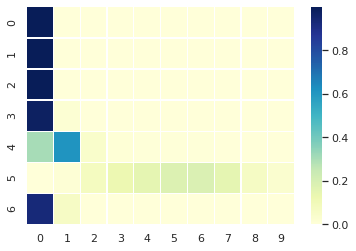

source:  the part lrb angle rrb from where the water passes out can be seen through a special lens
actual:  <sos> sos एक विशेष लैन्स द्वारा पानी के बाहर जाने के हिस्से  एंगल  को देख सकते हैं ।
predicted:  कैपस्यूलर एक्सट्रेक्शन एक्सट्रेक्शन एक्सट्रेक्शन विधि है । <eos>
BLEU Score:  0.18305025818318518


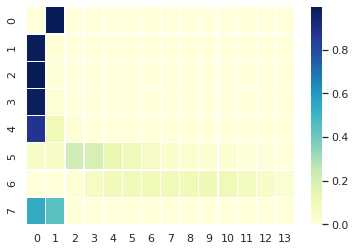

source:  with the lack of vitamina the cornea becomes weak and a wound appears through which at last causes blindness
actual:  <sos> sos विटामिनए की कमी से कॉर्नियल कमजोर तथा घाव हो जाते हैं जिससे अन्त में अन्धापन होता है ।
predicted:  बैग लक्षण लैन्स लैन्स लैन्स जाता । <eos>
BLEU Score:  0.18305025818318518


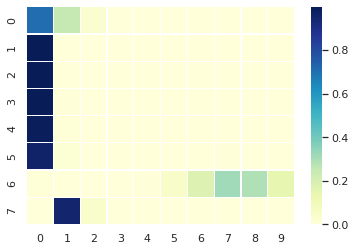

source:  the lack of vitamina is even more imminent in states of measles and malnutrition
actual:  <sos> sos विटामिनए की कमी खसरे तथा कुपोषण की स्थिति में और अधिक होती है ।
predicted:  कैपस्यूलर एक्सट्रेक्शन एक्सट्रेक्शन लैन्स विधि जाता । <eos>
BLEU Score:  0.18827362913939635


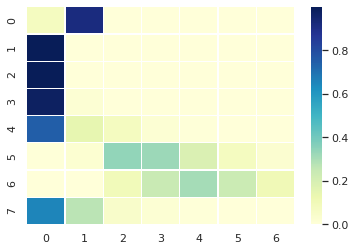

In [31]:
get_prediction(X_test,y_in_test,model)
get_prediction(X_train,y_in_train, model)

In [0]:
_X = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/dev.en', names=['src'])
_Y = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/dev.hi', names=['dest'])
_lines = pd.concat([_X,_Y], axis=1)
print(len(_lines))
_lines.sample(10)

In [0]:
_X, _y = lines.src.values, lines.dest.values 

In [0]:
get_prediction(_X,_y,model)

In [0]:
# nameoffile = "q42"
# with open(nameoffile, "wb") as dill_file:
#     dill.dump(model, dill_file)

In [0]:
# model = {}
# with open(nameoffile, "rb") as dill_file:
#   model = dill.load(dill_file)

In [37]:
# print(model['attn_type'])

LuongAttention
